In [1]:
import sys
import pandas as pd
import os

sys.path.append("..")

from drift_detector.explainer import ShiftExplainer
from experiments import *
from utils.constants import *
from utils.plot_utils import errorfill, plot_roc, plot_pr, linestyles, markers, colors, brightness, colorscale
from utils.legacy_utils import import_dataset, import_dataset_hospital, FEATURES
from utils.utils import run_synthetic_shift_experiment
from baseline_models.static.utils import run_model

2022-07-12 23:09:56,509 INFO cyclops.orm     - Database setup, ready to run queries!


## Functions ##

In [2]:
def summary_stats(X,y,label):
    data = pd.concat([X,y],axis=1)
    con = data.loc[data[label] == 0].describe()
    case = data.loc[data[label] == 1].describe() 
    stats = pd.concat([con,case],axis=0,keys=["controls","cases"])
    return(stats.T)

        
def setup_plot(plot_handle: mpl.axes.SubplotBase,
               title: str,
               xlabel: str,
               ylabel: str,
               legend: list):
    """Setup plot.
    
    Parameters
    ----------
    plot_handle: mpl.axes.SubplotBase
        Subplot handle.
    title: str
        Title of plot.
    xlabel: str
        Label for x-axis.
    ylabel: str
        Label for y-axis.
    legend: list
        Legend for different sub-groups.
    """
    plot_handle.title.set_text(title)
    plot_handle.set_xlabel(xlabel, fontsize=20)
    plot_handle.set_ylabel(ylabel, fontsize=20)  
    plot_handle.legend(legend, loc=1)
    
    
def set_bars_color(bars: mpl.container.BarContainer,
                   color: str):
    """Set color attribute for bars in bar plots.
    
    Parameters
    ----------
    bars: mpl.container.BarContainer
        Bars.
    color: str
        Color.
    """
    for bar in bars:
        bar.set_color(color)

def plot_admin(X,y,label):
    data = pd.concat([X,y],axis=1)
    data_pos = data.loc[data[label] == 1]
    data_neg = data.loc[data[label] == 0]
    ICDS = ["icd10_A00_B99","icd10_C00_D49","icd10_D50_D89","icd10_E00_E89", "icd10_F01_F99","icd10_G00_G99", "icd10_H00_H59",
    "icd10_H60_H95","icd10_I00_I99","icd10_J00_J99","icd10_K00_K95","icd10_L00_L99","icd10_M00_M99","icd10_N00_N99", "icd10_O00_O99","icd10_Q00_Q99","icd10_R00_R99", "icd10_S00_T88","icd10_U07_U08","icd10_Z00_Z99"]
    fig, axs = plt.subplots(2, 2, figsize=(30, 15), tight_layout=True)

    # Across age.
    ages = data[AGE]
    ages_pos = data_pos[AGE]
    ages_neg = data_neg[AGE]
    print(f"Mean Age: Outcome present: {np.array(ages_pos).mean()}, No outcome: {np.array(ages_neg).mean()}")

    (_, bins, _) = axs[0][0].hist(ages, bins=50, alpha=0.5, color='g')
    axs[0][0].hist(ages_pos, bins=bins, alpha=0.5, color='r')
    setup_plot(axs[0][0], 
               "Age distribution",
               "Age", 
               "Num. of admissions",
               ['All', 'Outcome present'])

    # Across sex.
    sex = list(data[SEX].unique())
    sex_counts = list(data[SEX].value_counts())
    sex_counts_pos = list(data_pos[SEX].value_counts())

    sex_bars = axs[0][1].bar(sex, sex_counts, alpha = 0.5)
    set_bars_color(sex_bars, 'g')
    sex_bars_pos = axs[0][1].bar(sex, sex_counts_pos, alpha = 0.5)
    set_bars_color(sex_bars_pos, 'r')
    setup_plot(axs[0][1], 
               "Sex distribution",
               "Sex", 
               "Num. of admissions",
               ['All', 'Outcome present'])

    # Across diagnosis codes.
    n = len(ICDS)                
    w = .04                       
    x = np.arange(0, len([0,1]))   
    #NUM_COLORS = 20
    #cm = plt.get_cmap('gist_rainbow')

    for i, icd in enumerate(ICDS):
        icd_counts = list(data[icd].value_counts())
        icd_counts_pos = list(data_pos[icd].value_counts())
        if len(icd_counts) == 1:
            icd_counts.append(0)
        if len(icd_counts_pos) == 1:
            icd_counts_pos.append(0)
        position = x + (w*(1-n)/2) + i*w
        icd_bars = axs[1][0].bar(position,icd_counts, width=w, alpha = 0.5)
        set_bars_color(icd_bars, 'g')
        icd_bars_pos = axs[1][0].bar(position, icd_counts_pos, width=w, alpha = 0.5)
        set_bars_color(icd_bars_pos, 'r')
        
    setup_plot(axs[1][0], 
               "ICD distribution",
               "ICD", 
               "Num. of admissions",
               ['All', 'Outcome present'])

    # Across labels.
    label_counts = y.value_counts().to_dict().values()
    labels = data[label].value_counts().to_dict().keys()

    label_bars = axs[1][1].bar(labels, label_counts, alpha = 0.5)
    set_bars_color(label_bars, 'g')
    setup_plot(axs[1][1], 
               "Label distribution",
               "Label", 
               "Num. of admissions",
               ['All'])

    plt.show()

###  Load data ###

Loading data...
Mean Age: Outcome present: 65.88293370944993, No outcome: 62.01891891891892


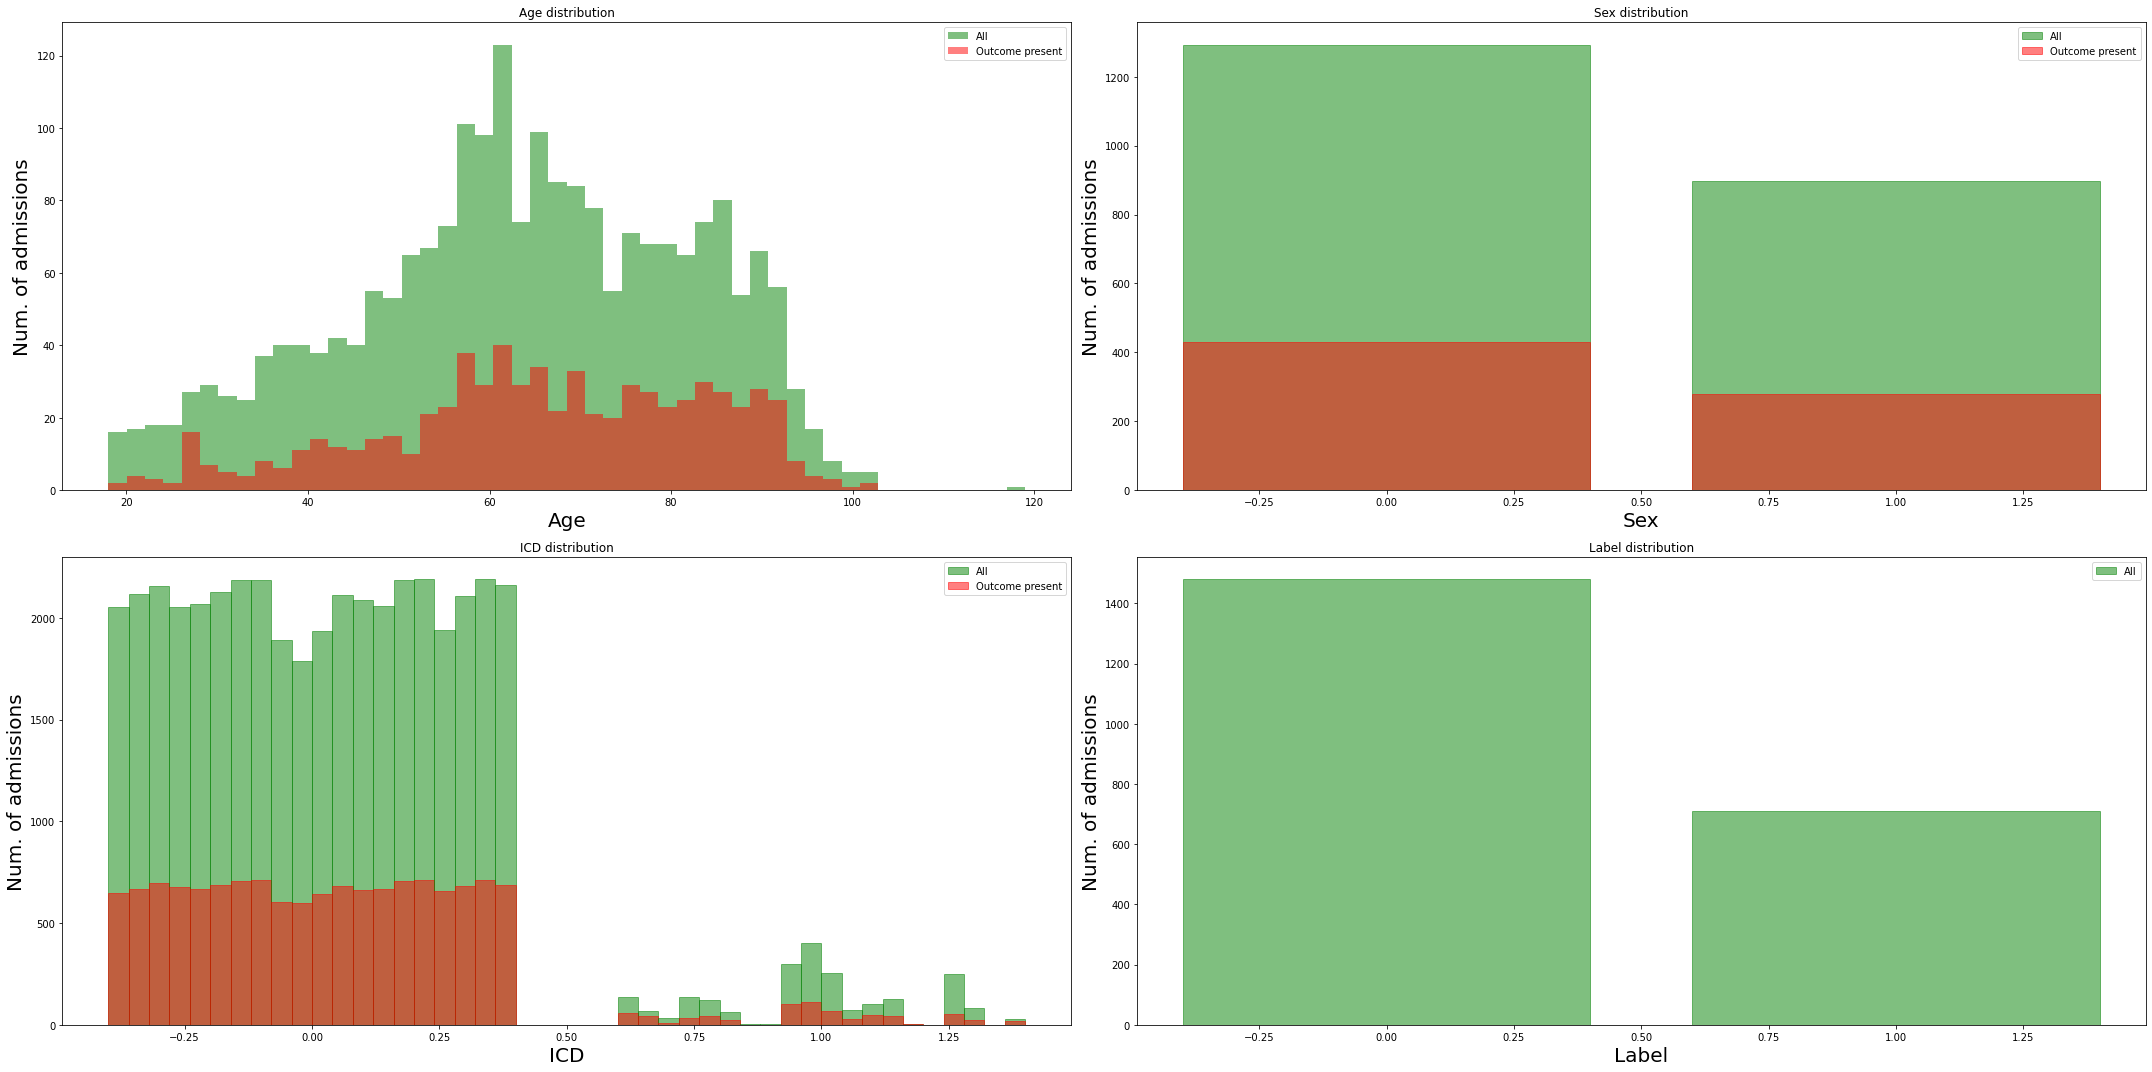

In [19]:
LABEL = "los"

print("Loading data...")
(X_s_tr, y_s_tr), (X_s_val, y_s_val), (X_t, y_t), orig_dims = import_dataset_hospital('los',[HOSPITAL_ID['SMH']],[HOSPITAL_ID['UHNTG']])
X = pd.DataFrame(X_s_tr,columns=features)
y = pd.DataFrame(y_s_tr,columns=[LABEL])
stats_2019_tr = summary_stats(X,y,LABEL)
plot_admin(X,y,LABEL)

### Define Shift Detector and Parameters ###

In [16]:
sign_level = 0.05
dr_technique = "PCA"
md_test = "MMD"
red_model = None
datset = "test experiment"
samples = [10, 20, 50, 100, 200, 500, 1000,2000]
sample = samples[5]
orig_dims = X_s_tr.shape[1:]
print("Building shift detector...")
sd = ShiftDetector(dr_technique, md_test, sign_level, red_model, sample, datset)

Building shift detector...


#### Drift from 2019 to 2019 ####

No GPU detected, fall back on CPU.
0.03999999910593033 0.003810286521911621
Mean Age: Outcome present: 66.60144927536231, No outcome: 61.314876584389594


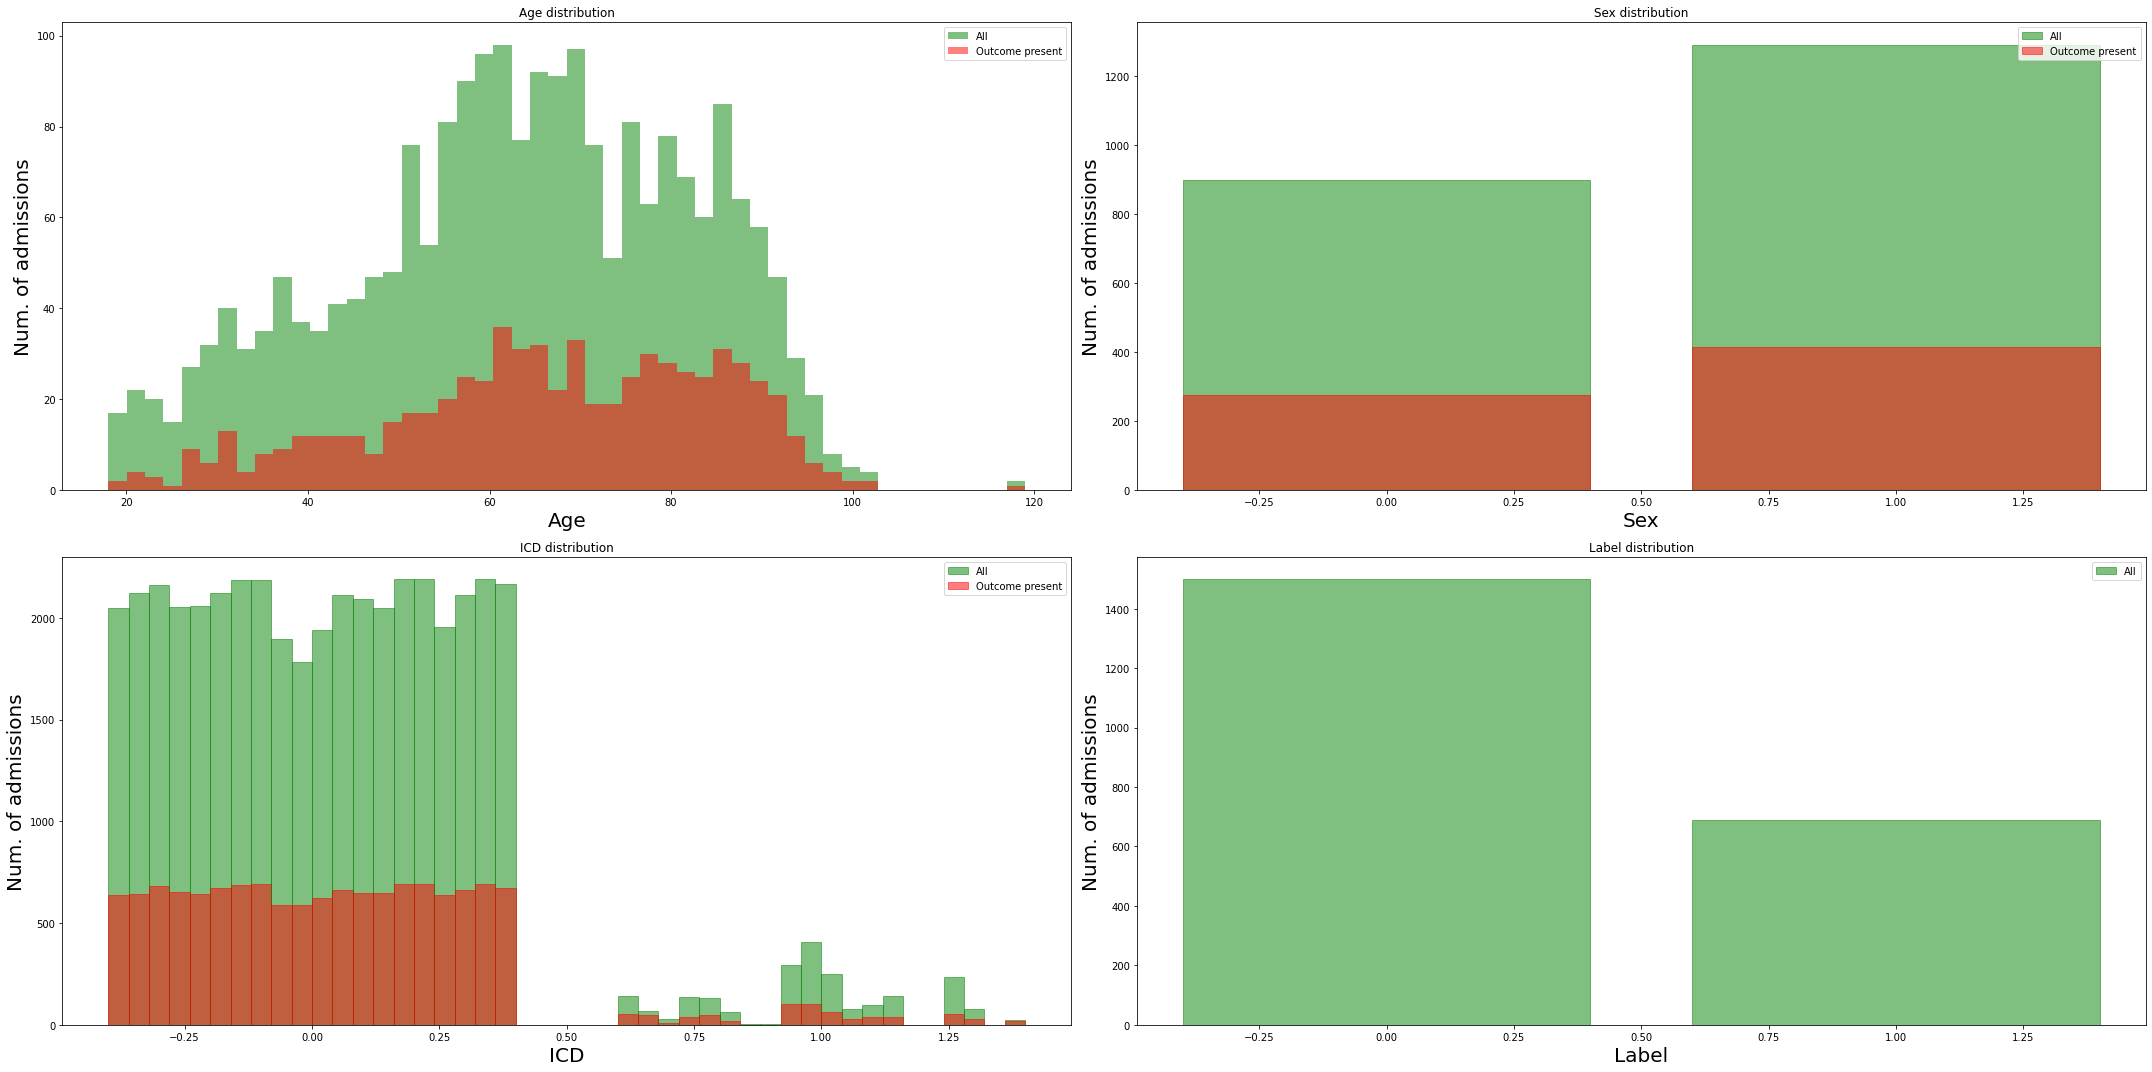

In [17]:
p_val, dist, red_dim, red_model, t1_acc, t2_acc = sd.detect_data_shift(X_s_tr, y_s_tr, X_s_tr, y_s_tr, X_s_val[:sample,:], y_s_val[:sample], orig_dims)
print(p_val,dist)

X = pd.DataFrame(X_s_val,columns=features)
y = pd.DataFrame(y_s_val,columns=[LABEL])
stats_2019_val = summary_stats(X,y,LABEL)
plot_admin(X,y,LABEL)

#### Drift from 2019 to 2020 ####

No GPU detected, fall back on CPU.
0.07000000029802322 0.002277851104736328
Mean Age: Outcome present: 66.57684529828109, No outcome: 61.79283078545071


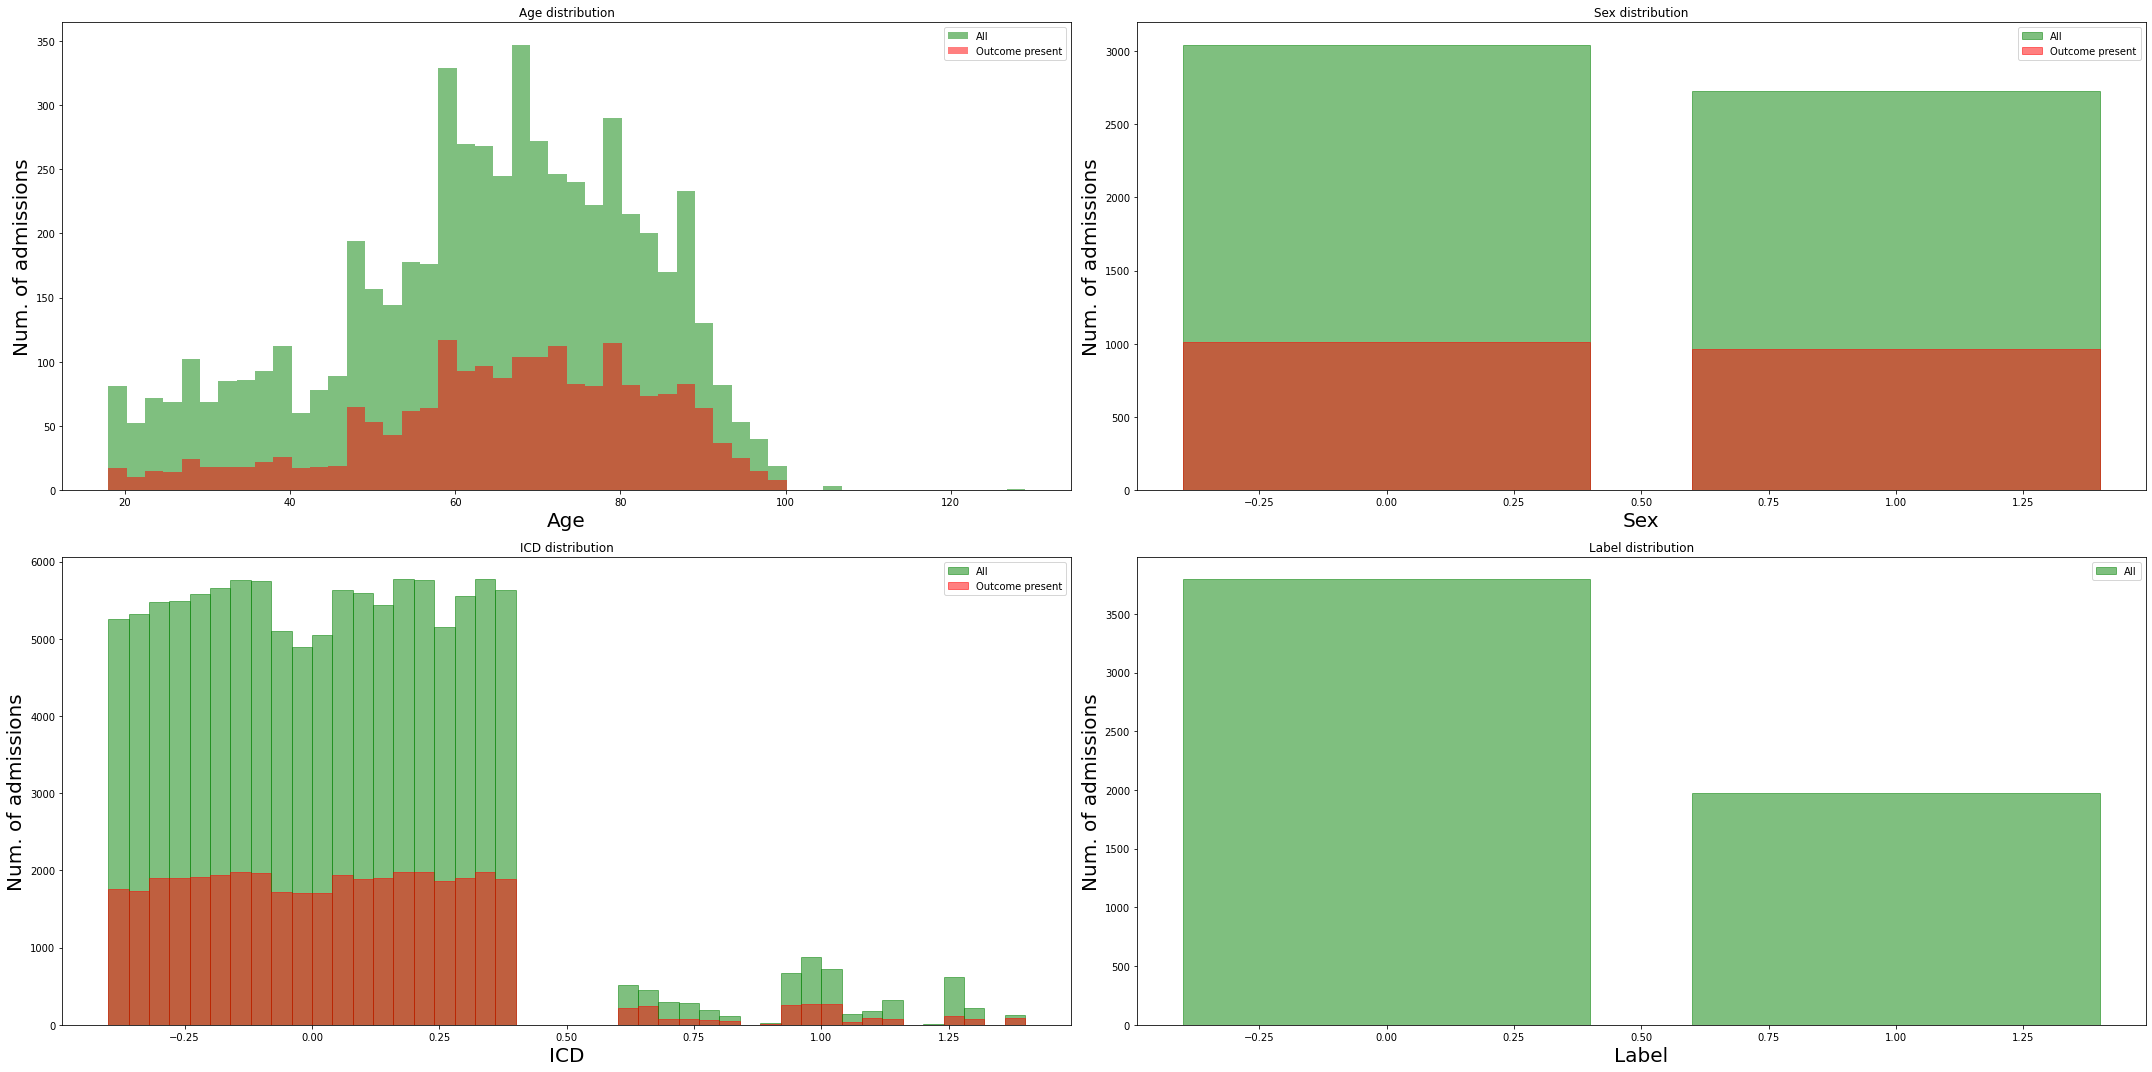

In [20]:
p_val, dist, red_dim, red_model, t1_acc, t2_acc = sd.detect_data_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, X_t[:sample,:], y_t[:sample], orig_dims)
print(p_val,dist)

X = pd.DataFrame(X_t,columns=features)
y = pd.DataFrame(y_t,columns=[LABEL])
stats_2020 = summary_stats(X,y,LABEL)
plot_admin(X,y,LABEL)

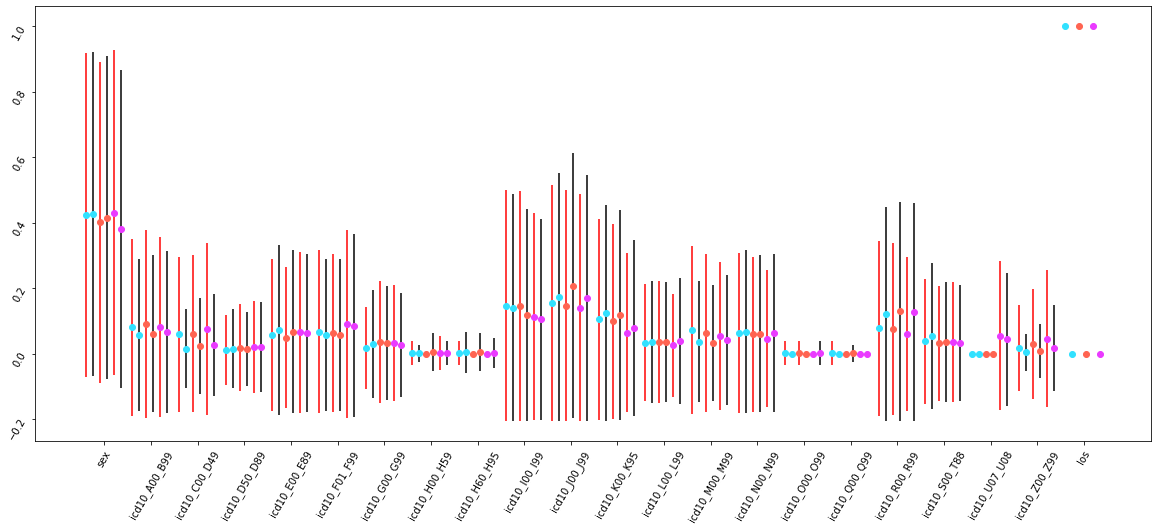

In [7]:
datasets=["2019_tr","2019_val","2020"]
stats = pd.concat([stats_2019_tr, stats_2019_val, stats_2020],keys=datasets,axis=1)
fig = plt.figure(figsize =(20, 8))
brightness = [1.5, 1.25, 1.0, 0.75, 0.5]
colors = ['#2196f3', '#f44336', '#9c27b0', '#64dd17','#009688','#ff9800','#795548', '#607d8b']
n = len(datasets)                
w = .3                   
x = np.arange(0, len(stats.index.values[1:]))   
for i,dataset in enumerate(datasets):
    position = x + (w*(1-n)/2) + i*w
    plt.errorbar(position, stats[dataset]['cases']['mean'].values[1:], stats[dataset]['cases']['std'].values[1:] ,fmt='o',ecolor = 'red',color = colorscale(colors[i],brightness[0]))
    plt.errorbar(position+0.15, stats[dataset]['controls']['mean'].values[1:], stats[dataset]['controls']['std'].values[1:] ,fmt='o',ecolor = 'black',color = colorscale(colors[i],brightness[0]))
    plt.xticks(position-0.2, stats.index.values[1:])
plt.tick_params(rotation=60)
plt.show()

#### Knockout Shift ####

No GPU detected, fall back on CPU.
0.8799999952316284 -0.0016568899154663086
Mean Age: Outcome present: 65.82336182336182, No outcome: 60.745625841184385


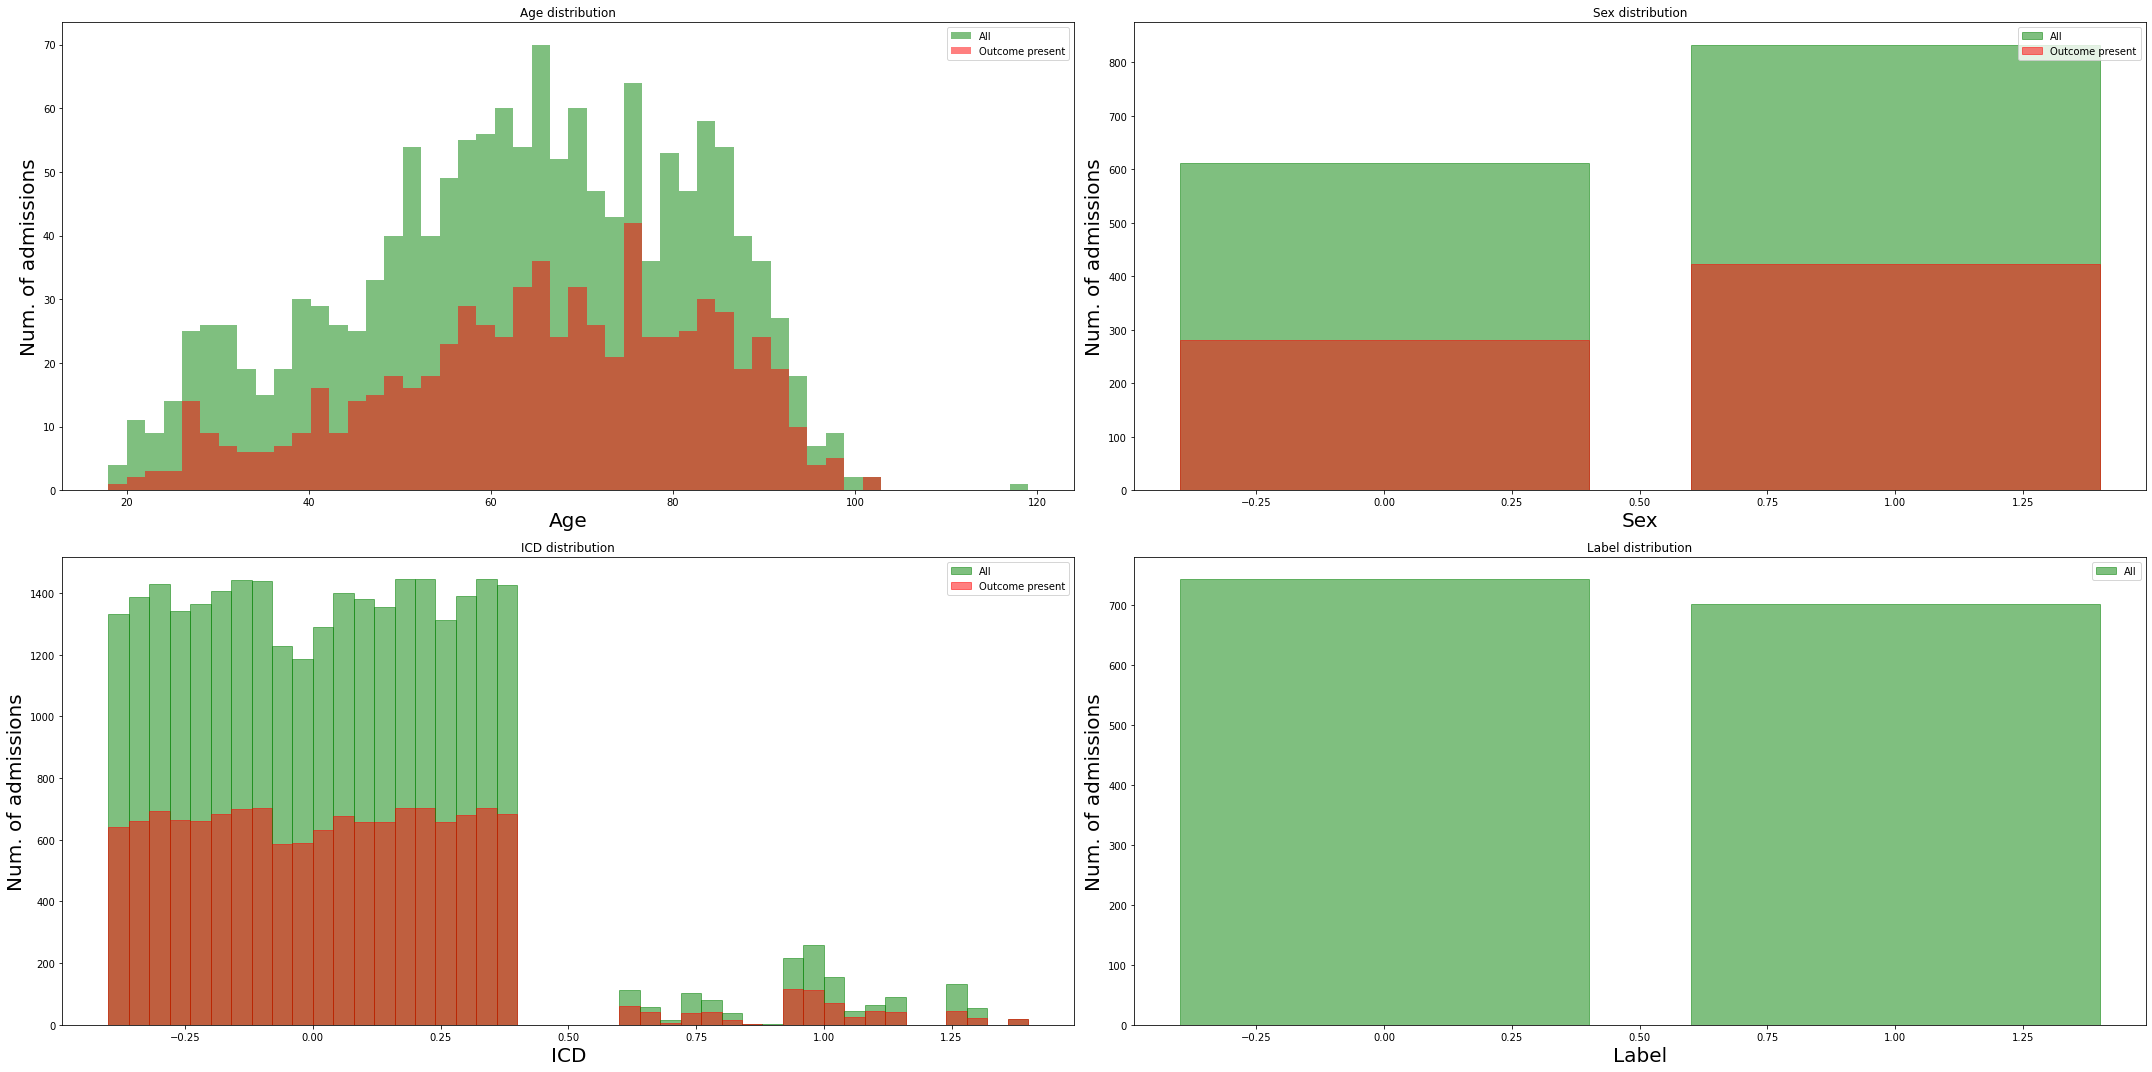

In [8]:
(X_s_tr, y_s_tr), (X_s_val, y_s_val), (X_t, y_t), orig_dims = import_dataset_year('los','2020')
shift = "ko_shift_0.5"
X_ko, y_ko = apply_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, shift)
p_val, dist, red_dim, red_model, t1_acc, t2_acc = sd.detect_data_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, X_ko[:sample,:], y_ko[:sample], orig_dims)
print(p_val,dist)
X = pd.DataFrame(X_ko,columns=features)
y = pd.DataFrame(y_ko,columns=[LABEL])
stats_ko = summary_stats(X,y,LABEL)
plot_admin(X,y,LABEL)

#### Small Gaussian Noise Shift ####

No GPU detected, fall back on CPU.
1.0 -0.0022827982902526855
Mean Age: Outcome present: 65.77635327635328, No outcome: 60.797579018157364


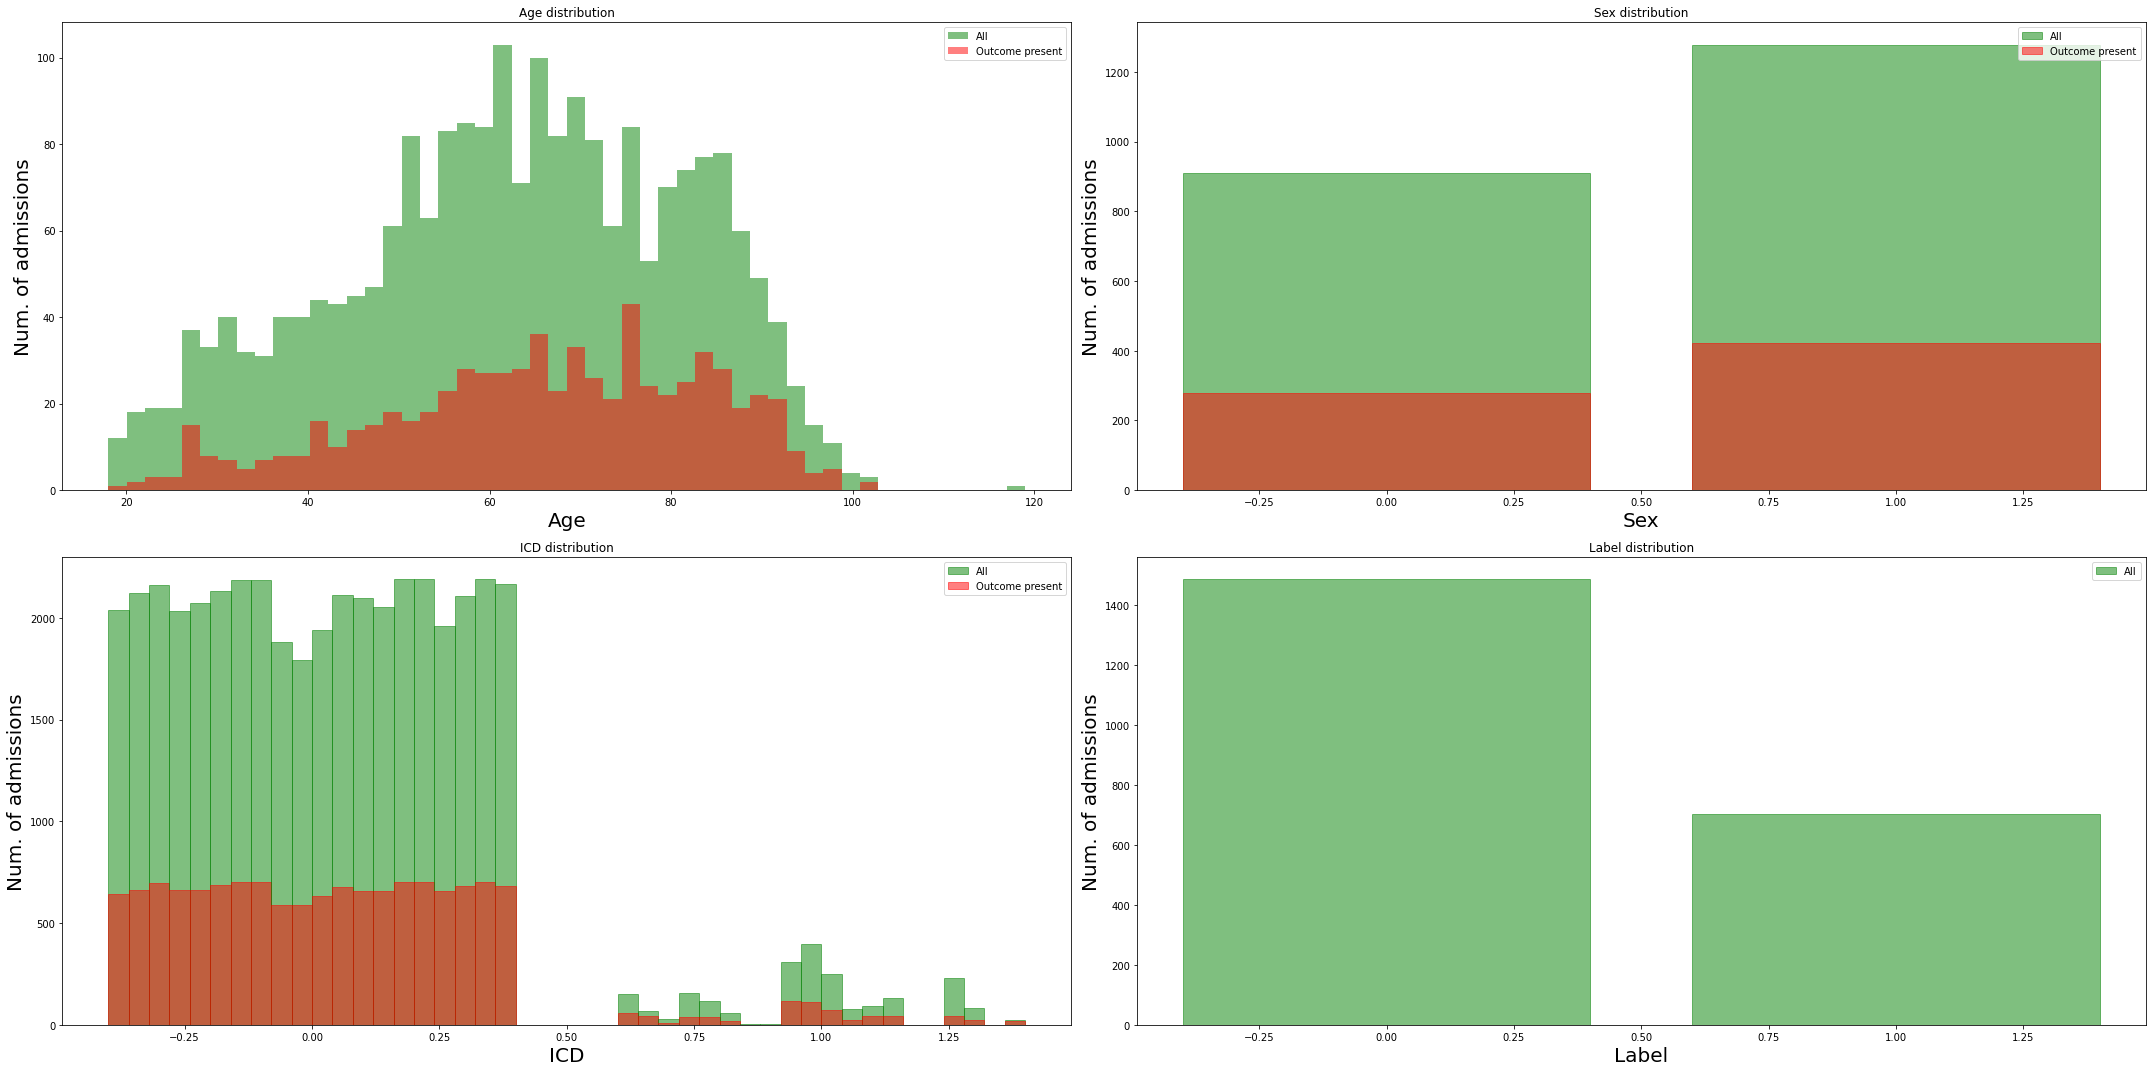

In [9]:
shift = "small_gn_shift_0.1"
X_sgn, y_sgn = apply_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, shift)
p_val, dist, red_dim, red_model, t1_acc, t2_acc = sd.detect_data_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, X_sgn[:sample,:], y_sgn[:sample], orig_dims)
print(p_val,dist)
X = pd.DataFrame(X_sgn,columns=features)
y = pd.DataFrame(y_sgn,columns=[LABEL])
stats_sgn = summary_stats(X,y,LABEL)
plot_admin(X,y,LABEL)

#### Large Gaussian Noise Shift ####

No GPU detected, fall back on CPU.
1.0 -0.002278566360473633
Mean Age: Outcome present: 66.04700854700855, No outcome: 63.90921318090114


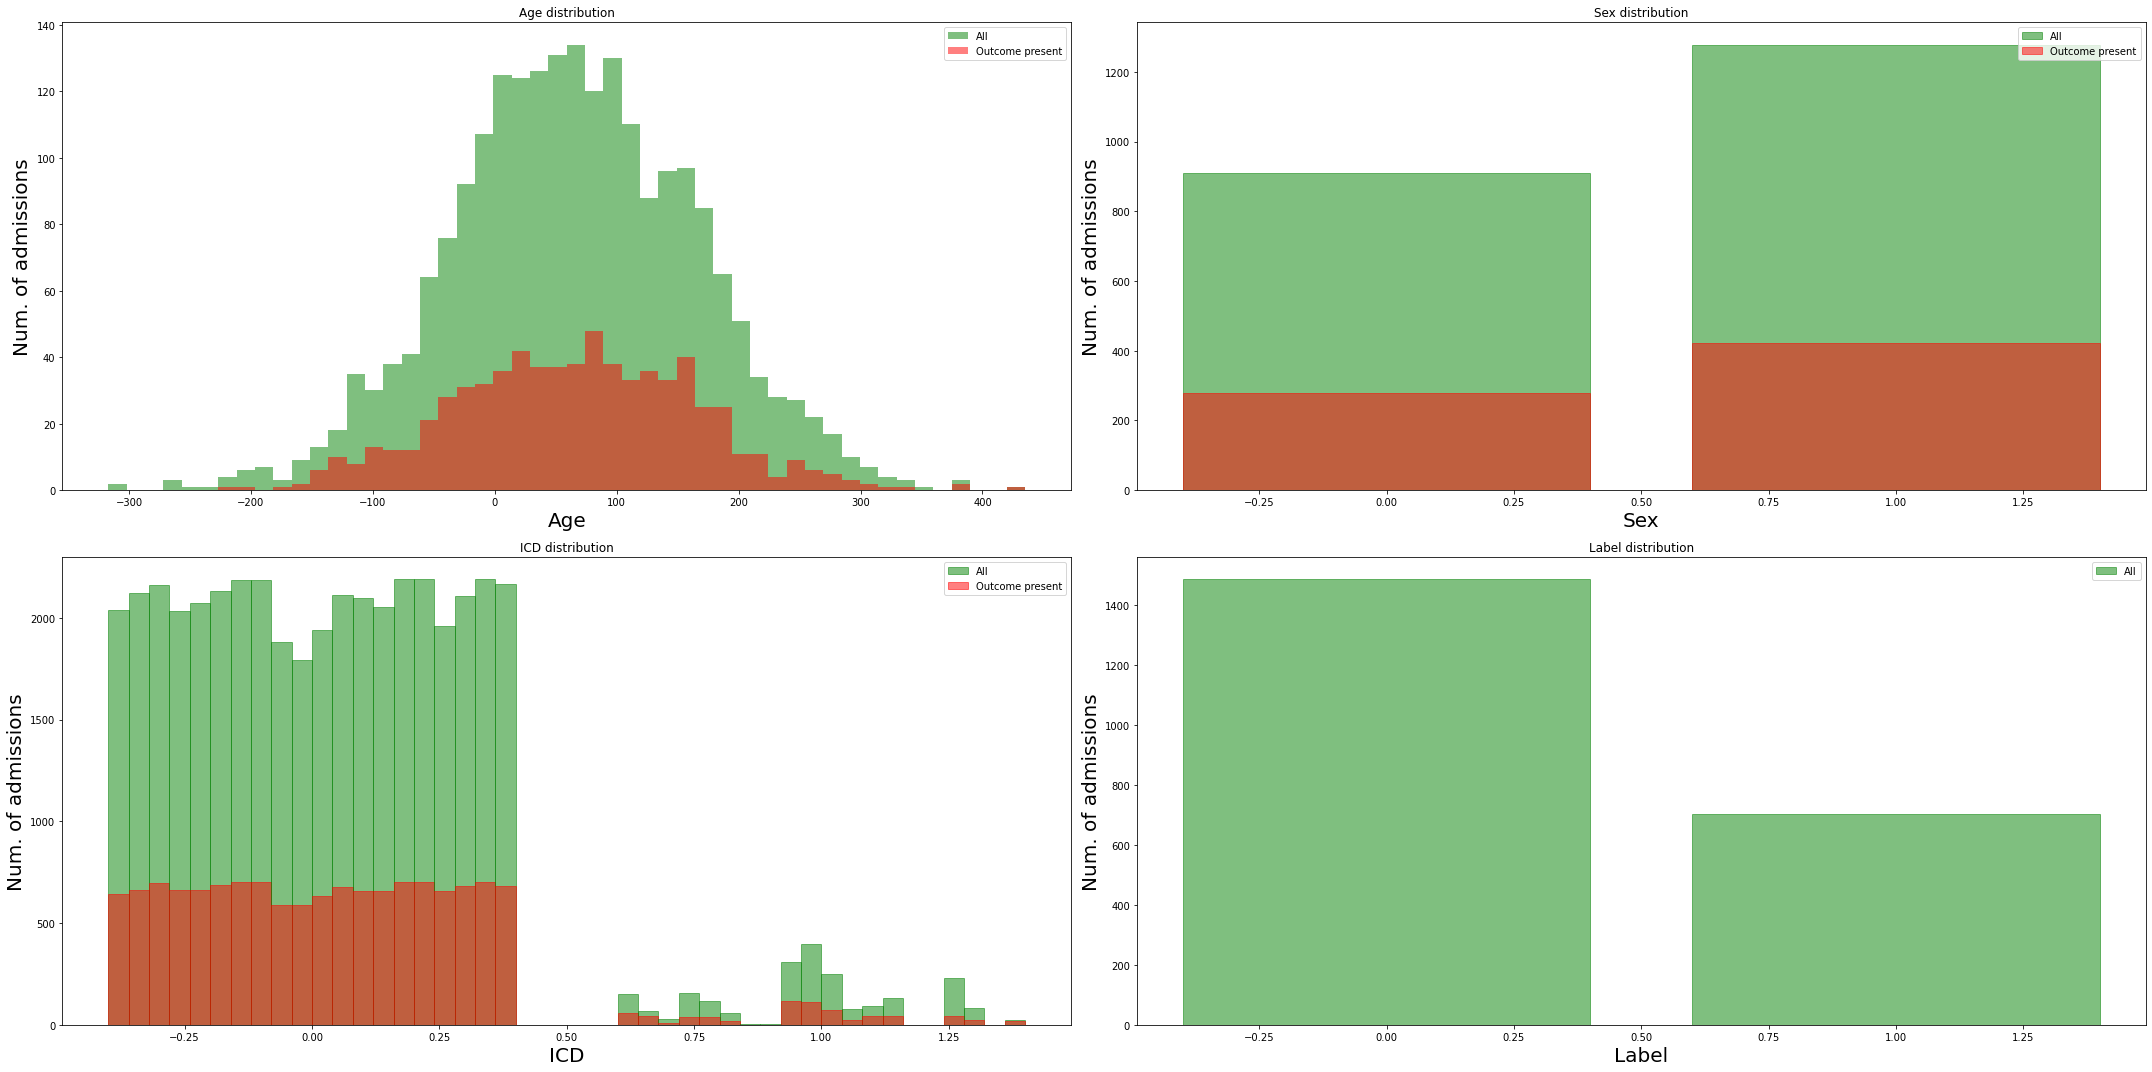

In [10]:
shift = "large_gn_shift_1.0"
X_lgn, y_lgn = apply_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, shift)
p_val, dist, red_dim, red_model, t1_acc, t2_acc = sd.detect_data_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, X_lgn[:sample,:], y_lgn[:sample], orig_dims)
print(p_val,dist)
X = pd.DataFrame(X_lgn,columns=features)
y = pd.DataFrame(y_lgn,columns=[LABEL])
stats_lgn = summary_stats(X,y,LABEL)
plot_admin(X,y,LABEL)

#### Multiway Feature Association Shift ####

No GPU detected, fall back on CPU.
1.0 -0.0022597312927246094
Mean Age: Outcome present: 63.48621190130624, No outcome: 61.98533333333334


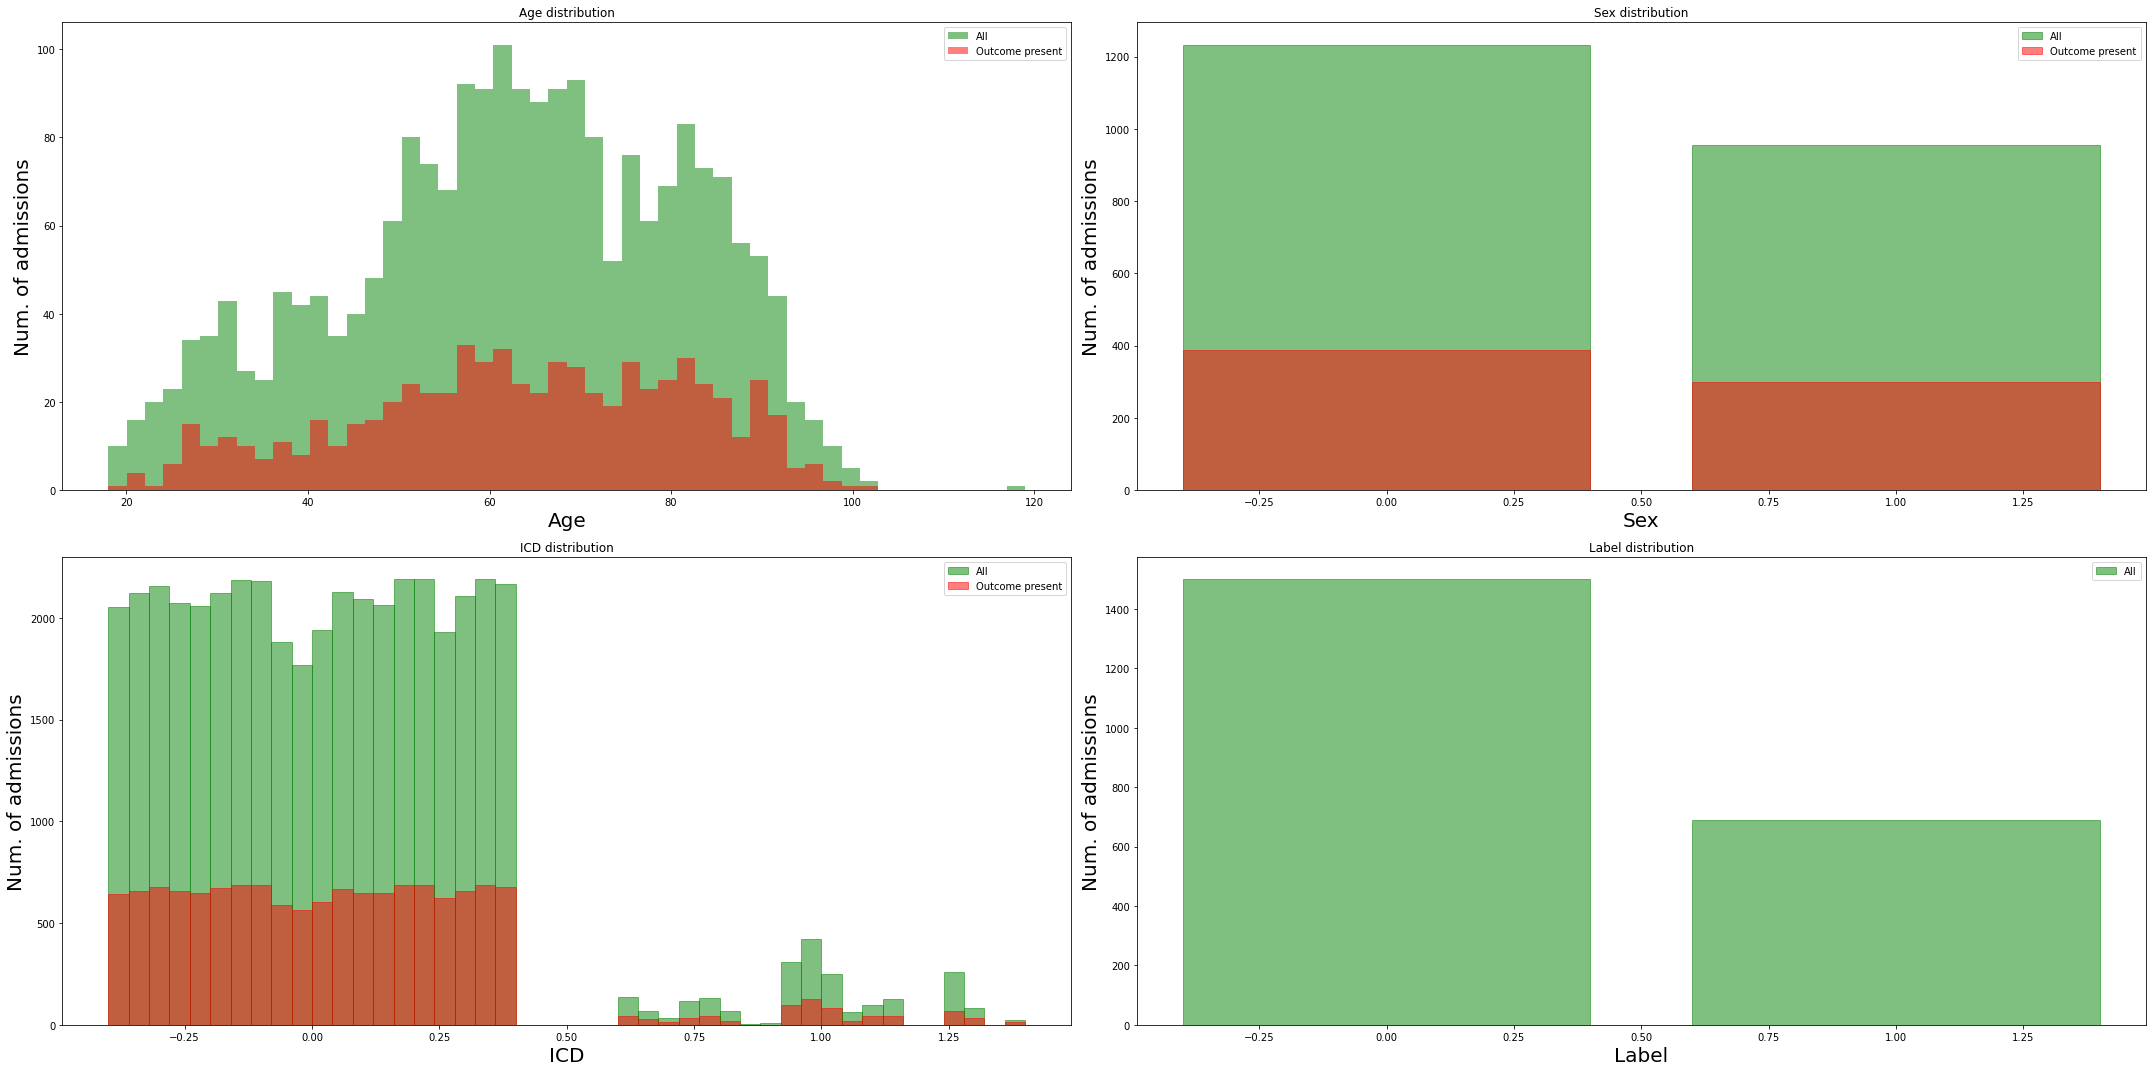

In [11]:
(X_s_tr, y_s_tr), (X_s_val, y_s_val), (X_t, y_t), orig_dims = import_dataset_year('los','2020')
shift = "mfa_shift_0.5"
X_mfa, y_mfa = apply_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, shift)
p_val, dist, red_dim, red_model, t1_acc, t2_acc = sd.detect_data_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, X_mfa[:sample,:], y_mfa[:sample], orig_dims)
print(p_val,dist)
X = pd.DataFrame(X_mfa,columns=features)
y = pd.DataFrame(y_mfa,columns=[LABEL])
stats_mfa = summary_stats(X,y,LABEL)
plot_admin(X,y,LABEL)

#### Changepoint Shift ####

Features [20] are constant.
invalid value encountered in true_divide


No GPU detected, fall back on CPU.
1.0 -0.002272486686706543
Mean Age: Outcome present: 63.48621190130624, No outcome: 61.98533333333334


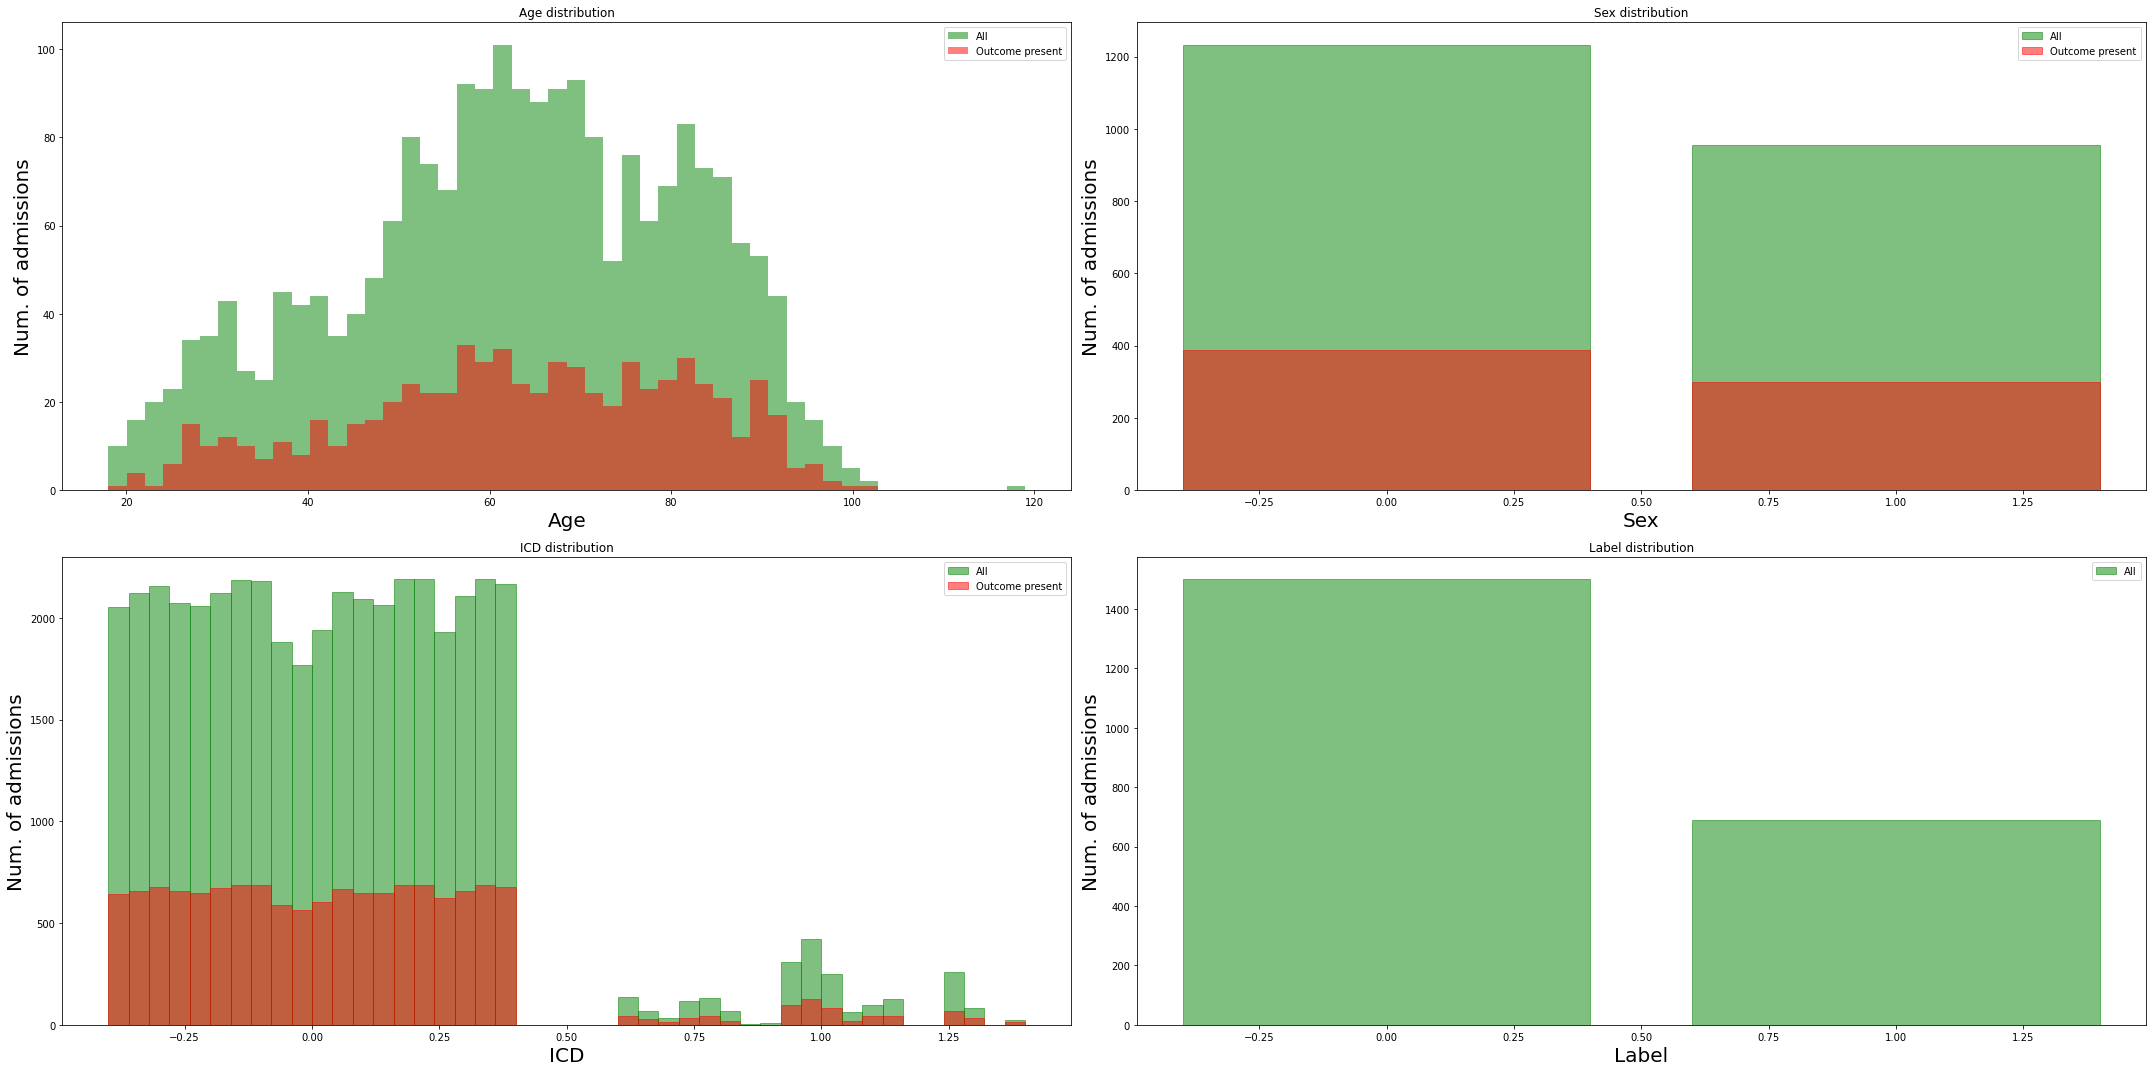

In [12]:
(X_s_tr, y_s_tr), (X_s_val, y_s_val), (X_t, y_t), orig_dims = import_dataset_year('los','2020')
shift= "cp_shift_0.75"
X_cp, y_cp = apply_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, shift)
p_val, dist, red_dim, red_model, t1_acc, t2_acc = sd.detect_data_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, X_cp[:sample,:], y_cp[:sample], orig_dims)
print(p_val,dist)
X = pd.DataFrame(X_mfa,columns=features)
y = pd.DataFrame(y_mfa,columns=[LABEL])
stats_cp = summary_stats(X,y,LABEL)
plot_admin(X,y,LABEL)

### Binary ###

No GPU detected, fall back on CPU.
1.0 -0.0022832155227661133
Mean Age: Outcome present: 66.37810218978102, No outcome: 61.190824468085104


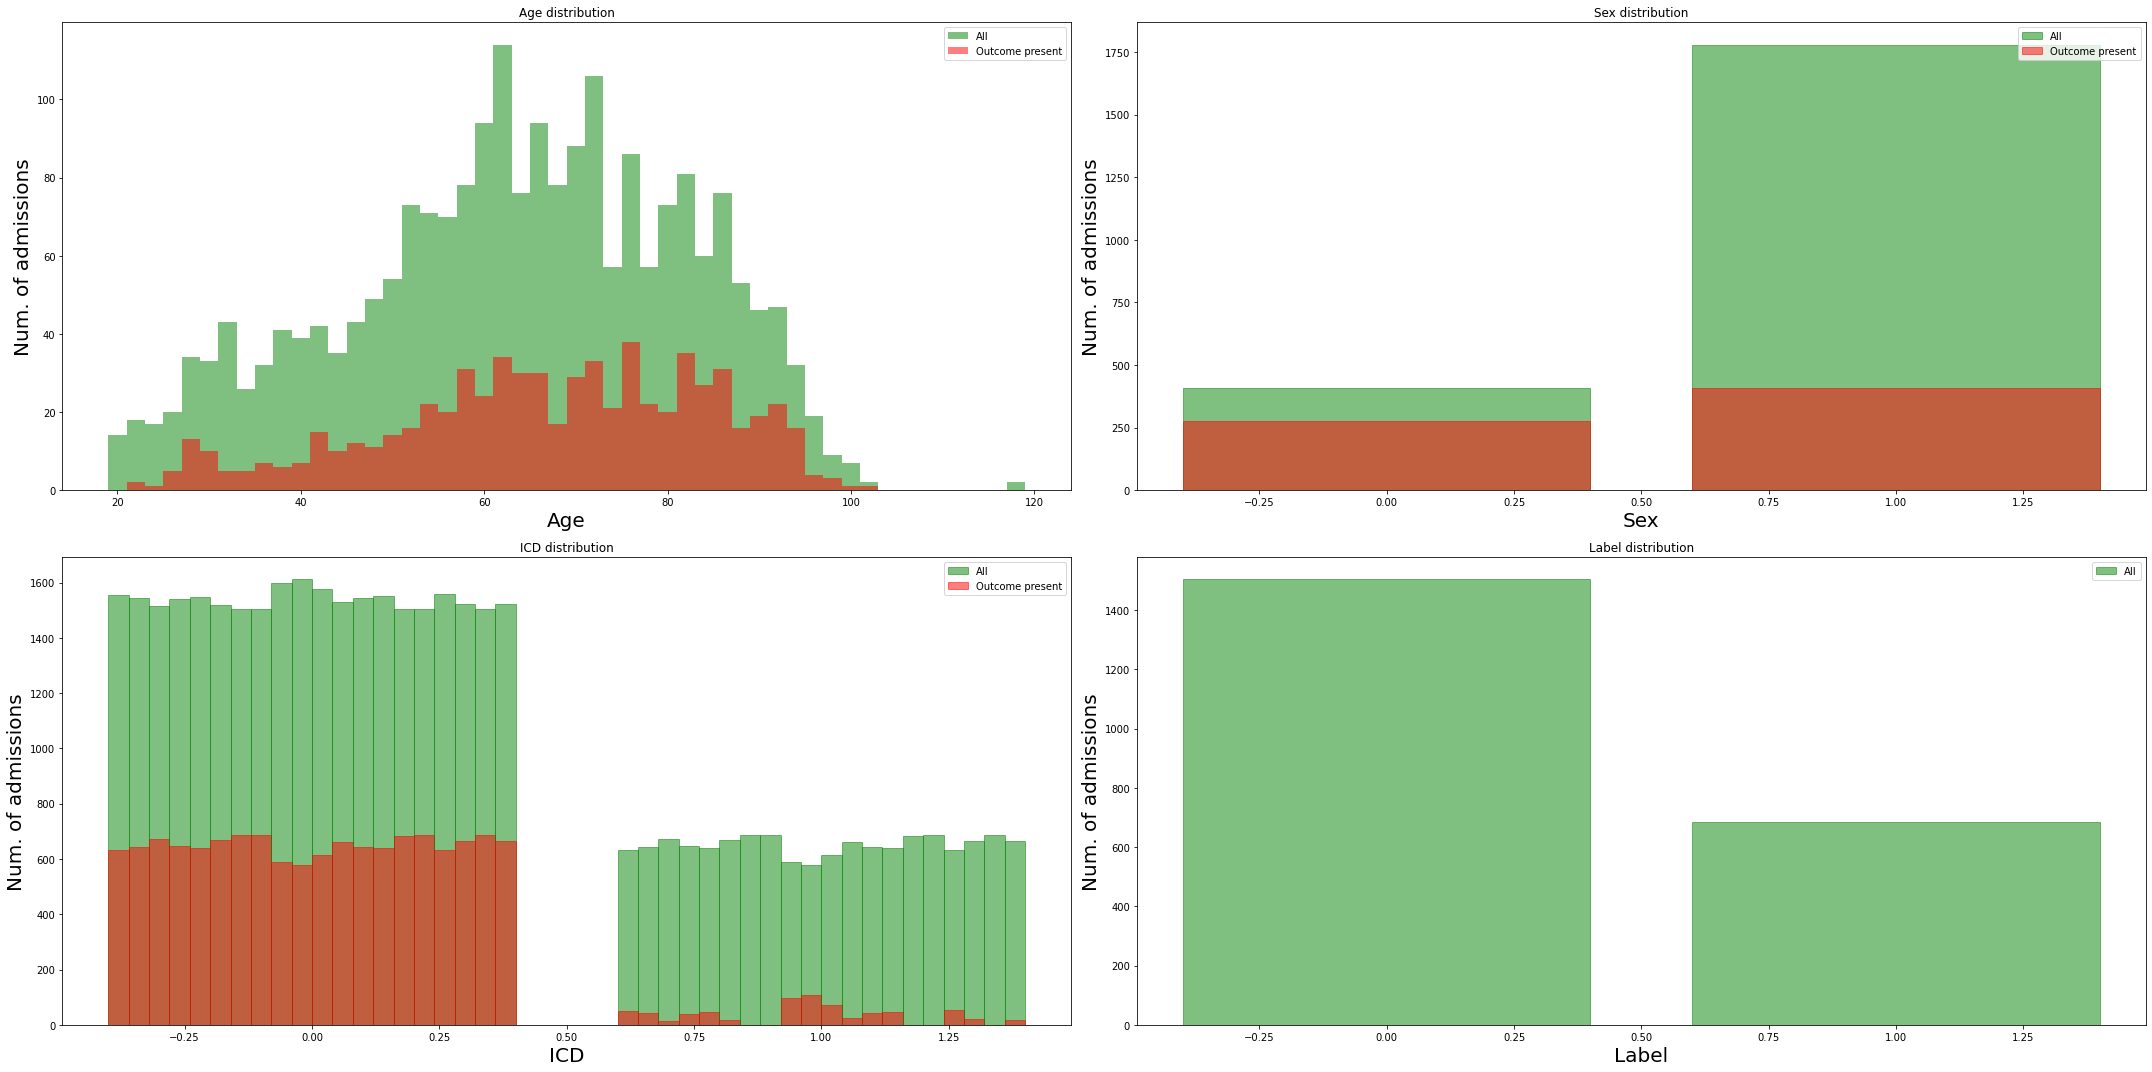

In [15]:
shift = "large_bn_shift_1.0"
X_bn, y_bn = apply_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, shift)
p_val, dist, red_dim, red_model, t1_acc, t2_acc = sd.detect_data_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, X_bn[:sample,:], y_bn[:sample], orig_dims)
print(p_val,dist)
X = pd.DataFrame(X_bn,columns=features)
y = pd.DataFrame(y_bn,columns=[LABEL])
stats_bn = summary_stats(X,y,LABEL)
plot_admin(X,y,LABEL)

In [ ]:
datasets=["2019_val","ko","bn"]
stats = pd.concat([stats_2019_val, stats_ko, stats_bn],keys=datasets,axis=1)
fig = plt.figure(figsize =(20, 8))
brightness = [1.5, 1.25, 1.0, 0.75, 0.5]
colors = ['#2196f3', '#f44336', '#9c27b0', '#64dd17','#009688','#ff9800','#795548', '#607d8b']
n = len(datasets)                
w = .3                      
x = np.arange(0, len(stats.index.values[1:]))   
for i,dataset in enumerate(datasets):
    position = x + (w*(1-n)/2) + i*w
    plt.errorbar(position, stats[dataset]['cases']['mean'].values[1:], stats[dataset]['cases']['std'].values[1:] ,fmt='o',ecolor = 'red',color = colorscale(colors[i],brightness[0]))
    plt.errorbar(position+0.15, stats[dataset]['controls']['mean'].values[1:], stats[dataset]['controls']['std'].values[1:] ,fmt='o',ecolor = 'black',color = colorscale(colors[i],brightness[0]))
    plt.xticks(position-0.2, stats.index.values[1:])
plt.tick_params(rotation=60)
plt.show()